<a href="https://colab.research.google.com/github/HealMaDe/ViT_Patch_Trial/blob/main/Breastmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU detected")
    print("Device name:", torch.cuda.get_device_name(0))
    print("Memory allocated:", round(torch.cuda.memory_allocated(0)/1024**2, 1), "MB")
    print("Memory reserved:", round(torch.cuda.memory_reserved(0)/1024**2, 1), "MB")
else:
    print("❌ No GPU detected, using CPU")


✅ GPU detected
Device name: Tesla T4
Memory allocated: 0.0 MB
Memory reserved: 0.0 MB


In [ ]:
import os, time, csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import timm
import numpy as np
from PIL import Image
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [ ]:
#Setup

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
IMG_SIZE = 28  # keep original size
EPOCHS = 120
LR = 1e-4
DATA_PATH = "./breastmnist.npz"
SAVE_DIR = "./results"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
model_name = "vit_tiny_patch16_224" # or vit_small_patch16_224, vit_base_patch16_224
patch_size = 28, #try  14,7,4,2,1

In [ ]:
#data loaer
class BreastMNISTDataset(Dataset):
    def __init__(self, split, npz_path=DATA_PATH, transform=None):
        data = np.load(npz_path)
        if split == "train":
            self.images, self.labels = data["train_images"], data["train_labels"]
        elif split == "val":
            self.images, self.labels = data["val_images"], data["val_labels"]
        elif split == "test":
            self.images, self.labels = data["test_images"], data["test_labels"]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")


        self.labels = self.labels.reshape(-1)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx])

        img = Image.fromarray((img * 255).astype(np.uint8)).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


#augmentation
train_transform = T.Compose([
    T.RandomResizedCrop(28, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor()
])


val_transform = T.Compose([
    T.ToTensor()
])

train_ds = BreastMNISTDataset("train", transform=train_transform)
val_ds   = BreastMNISTDataset("val", transform=val_transform)
test_ds  = BreastMNISTDataset("test", transform=val_transform)


train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_ds.labels.flatten()))




def get_model(model_name="vit_base_patch16_224", patch_size=28, img_size=28):
    if isinstance(img_size, int):
        img_size = (img_size, img_size)
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=NUM_CLASSES,
        patch_size=patch_size,
        img_size=img_size
    )

    return model.to(DEVICE)


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    epoch_time = time.time() - t0
    return running_loss / total, correct / total, epoch_time



@torch.no_grad()
def evaluate(model, loader, criterion, save_csv=None):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds_class = []
    all_probs = []

    # sync for accurate timing on GPU
    if DEVICE == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE); labels = labels.long().to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        preds_class = outputs.argmax(1)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds_class.extend(preds_class.cpu().numpy().tolist())
        # for binary: save prob of positive class; for multiclass save the whole row
        if probs.shape[1] == 2:
            all_probs.extend(probs[:, 1].tolist())          # (N,) list of positive prob
        else:
            all_probs.extend(probs.tolist())                # list of lists (N, C)

    if DEVICE == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    fps = len(all_labels) / elapsed if elapsed > 0 else 0.0

    acc = np.mean(np.array(all_labels) == np.array(all_preds_class))
    bal_acc = balanced_accuracy_score(all_labels, all_preds_class)

    # compute AUC
    try:
        if NUM_CLASSES == 2:
            auc = roc_auc_score(all_labels, np.array(all_probs))  # probs is (N,) for positive class
        else:
            auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='macro')
    except Exception as e:
        print("roc_auc_score error:", e)
        auc = 0.0

    # save predictions & probs
    if save_csv is not None:
        with open(save_csv, "w", newline="") as f:
            writer = csv.writer(f)
            if NUM_CLASSES == 2:
                writer.writerow(["label", "pred_class", "prob_pos"])
                for y, phat, ppos in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat, ppos])
            else:
                writer.writerow(["label", "pred_class"] + [f"prob_{i}" for i in range(NUM_CLASSES)])
                for y, phat, probs_row in zip(all_labels, all_preds_class, all_probs):
                    writer.writerow([y, phat] + probs_row)

    return running_loss / len(loader.dataset), acc, bal_acc, auc, elapsed, fps


def run_experiment(model_name, patch_size):
    print(f"\n===== Training {model_name} with patch size {patch_size} (input {IMG_SIZE}) =====")
    model = get_model(model_name, patch_size=patch_size, img_size=IMG_SIZE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

    # StepLR scheduler (reduce LR by 0.5 every 30 epochs)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": [], "val_auc": []}

    best_val_loss = float("inf")   # track best by validation loss
    best_ckpt = None

    # reset peak memory statistics only if CUDA available
    if DEVICE == "cuda":
        torch.cuda.reset_peak_memory_stats()

    total_train_time = 0.0
    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, epoch_time = train_one_epoch(model, train_loader, optimizer, criterion)
        total_train_time += epoch_time
        val_loss, val_acc, val_bal_acc, val_auc, _, _ = evaluate(model, val_loader, criterion)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| LR {optimizer.param_groups[0]['lr']:.2e} "
              f"| Train loss {train_loss:.4f} acc {train_acc:.4f} "
              f"| Val loss {val_loss:.4f} acc {val_acc:.4f} bal_acc {val_bal_acc:.4f} auc {val_auc:.4f} "
              f"| epoch_time {epoch_time:.2f}s")

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_auc"].append(val_auc)

        # Save best checkpoint by lowest validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_ckpt = f"{SAVE_DIR}/best_{model_name}_p{patch_size}_28.pth"
            torch.save(model.state_dict(), best_ckpt)


        scheduler.step()

    # load best and evaluate on test set
    if best_ckpt is None:
        print("No checkpoint saved (no improvement). Using last model weights.")
        best_ckpt = f"{SAVE_DIR}/last_{model_name}_p{patch_size}_28.pth"
        torch.save(model.state_dict(), best_ckpt)

    model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))

    test_loss, test_acc, test_bal_acc, test_auc, test_time, fps = evaluate(
        model, test_loader, criterion,
        save_csv=f"{SAVE_DIR}/preds_{model_name}_p{patch_size}_28.csv"
    )

    peak_vram_mb = torch.cuda.max_memory_allocated() / (1024**2) if DEVICE == "cuda" else "N/A"

    print("\n=== Final test results ===")
    print(f"Model: {model_name}  patch: {patch_size}  input: {IMG_SIZE}")
    print(f"Test loss: {test_loss:.4f}  acc: {test_acc:.4f}  bal_acc: {test_bal_acc:.4f}  auc: {test_auc:.4f}")
    print(f"Total train time: {total_train_time:.2f}s  Test time: {test_time:.2f}s  Inference FPS: {fps:.2f}")
    print(f"Peak VRAM (MB): {peak_vram_mb}\n")

    # --- Plot curves ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history["train_acc"], label="Train")
    plt.plot(history["val_acc"], label="Val")
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history["val_auc"], label="Val AUC")
    plt.title("Validation AUC"); plt.xlabel("Epoch"); plt.legend()

    plt.tight_layout()
    plot_path = f"{SAVE_DIR}/curves_{model_name}_p{patch_size}_28.png"
    plt.savefig(plot_path)

    #plt.close()
    print(f"Saved training curves to {plot_path}")
    plt.show()


===== Training vit_tiny_patch16_224 with patch size 28 (input 28) =====


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.6438 acc 0.7198 | Val loss 0.6083 acc 0.7308 bal_acc 0.5000 auc 0.8112 | epoch_time 3.06s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5819 acc 0.7143 | Val loss 0.6087 acc 0.7308 bal_acc 0.5000 auc 0.8145 | epoch_time 1.72s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.6113 acc 0.7234 | Val loss 0.5693 acc 0.7308 bal_acc 0.5000 auc 0.7828 | epoch_time 1.69s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5656 acc 0.7381 | Val loss 0.4721 acc 0.8590 bal_acc 0.7381 auc 0.7636 | epoch_time 1.76s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5959 acc 0.7179 | Val loss 0.5304 acc 0.7308 bal_acc 0.5000 auc 0.7945 | epoch_time 1.73s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5358 acc 0.7326 | Val loss 0.4509 acc 0.8333 bal_acc 0.7055 auc 0.8003 | epoch_time 1.98s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5521 acc 0.7418 | Val loss 0.4464 acc 0.8590 bal_acc 0.7381 auc 0.8137 | epoch_time 2.07s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.5429 acc 0.7436 | Val loss 0.4814 acc 0.84

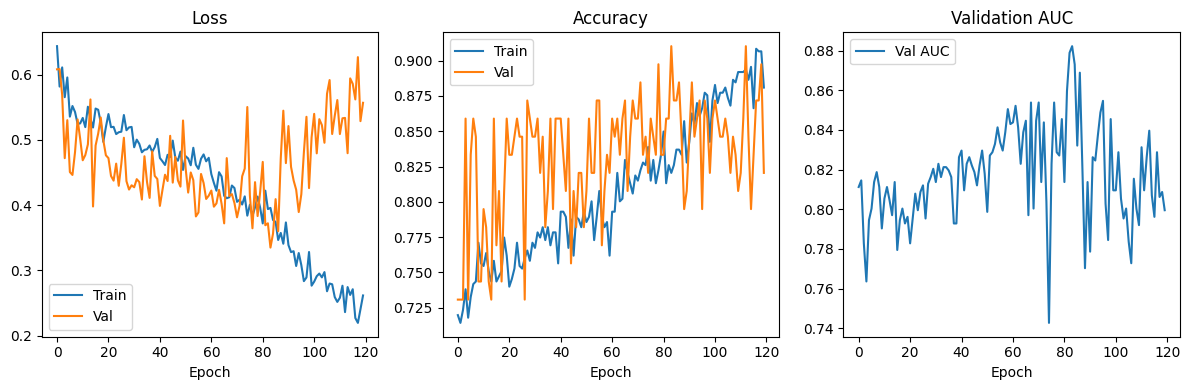


===== Training vit_tiny_patch16_224 with patch size 14 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6579 acc 0.6923 | Val loss 0.5970 acc 0.7308 bal_acc 0.5000 auc 0.8262 | epoch_time 2.33s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5783 acc 0.7271 | Val loss 0.5459 acc 0.7308 bal_acc 0.5000 auc 0.7544 | epoch_time 1.80s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5644 acc 0.7289 | Val loss 0.5053 acc 0.7821 bal_acc 0.6103 auc 0.7962 | epoch_time 1.73s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5515 acc 0.7601 | Val loss 0.4987 acc 0.7821 bal_acc 0.5952 auc 0.7753 | epoch_time 1.73s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5523 acc 0.7326 | Val loss 0.5444 acc 0.7308 bal_acc 0.5000 auc 0.8028 | epoch_time 1.74s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5448 acc 0.7436 | Val loss 0.4977 acc 0.7564 bal_acc 0.5476 auc 0.7577 | epoch_time 1.71s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5212 acc 0.7711 | Val loss 0.5574 acc 0.7564 bal_acc 0.5476 auc 0.8237 | epoch_time 2.36s
Epoch 8/12

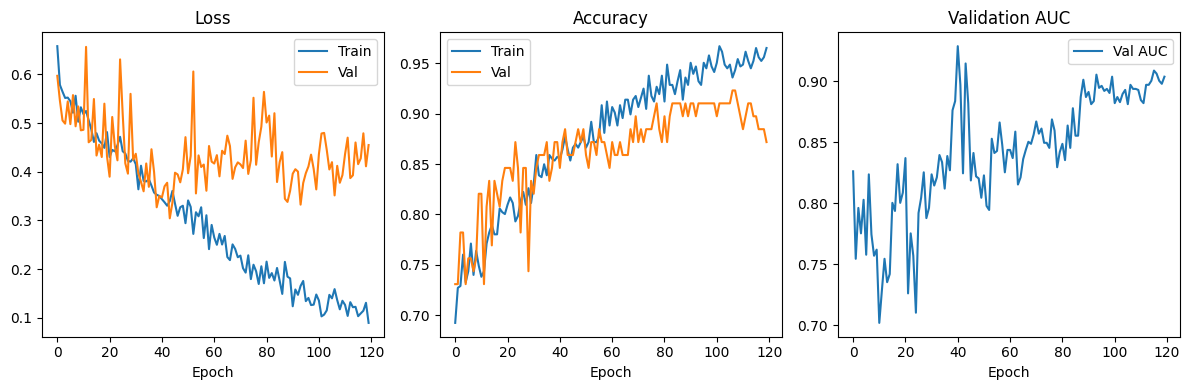


===== Training vit_tiny_patch16_224 with patch size 7 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6112 acc 0.7143 | Val loss 0.5048 acc 0.7821 bal_acc 0.6103 auc 0.7786 | epoch_time 1.75s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.6051 acc 0.7326 | Val loss 0.5819 acc 0.7308 bal_acc 0.5000 auc 0.7026 | epoch_time 1.77s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5564 acc 0.7509 | Val loss 0.5685 acc 0.7308 bal_acc 0.5000 auc 0.7970 | epoch_time 1.72s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5822 acc 0.7308 | Val loss 0.5070 acc 0.8205 bal_acc 0.7719 auc 0.8413 | epoch_time 1.77s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5368 acc 0.7344 | Val loss 0.4091 acc 0.8590 bal_acc 0.7531 auc 0.8421 | epoch_time 1.86s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5063 acc 0.7527 | Val loss 0.4101 acc 0.8718 bal_acc 0.7769 auc 0.8471 | epoch_time 2.15s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.4577 acc 0.8132 | Val loss 0.4491 acc 0.8077 bal_acc 0.6429 auc 0.8521 | epoch_time 1.74s
Epoch 8/120

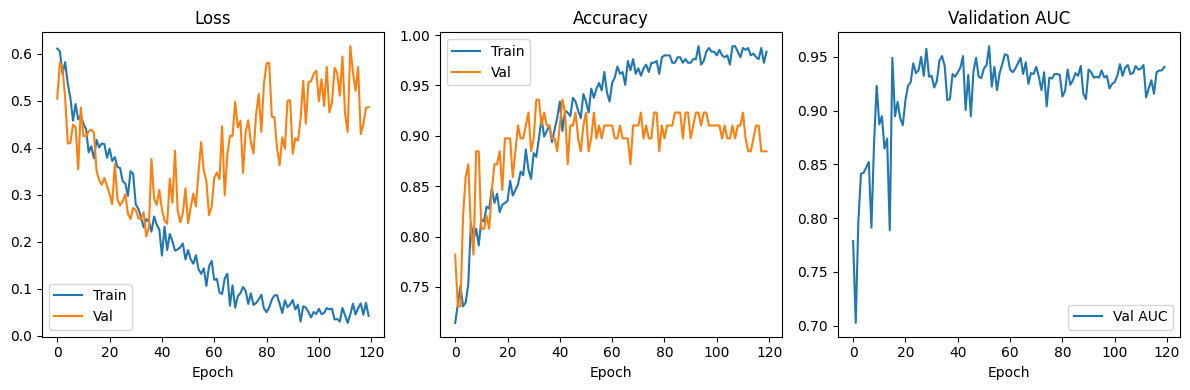


===== Training vit_tiny_patch16_224 with patch size 4 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6799 acc 0.6905 | Val loss 0.5796 acc 0.7308 bal_acc 0.5000 auc 0.6575 | epoch_time 1.76s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5834 acc 0.7326 | Val loss 0.5504 acc 0.7308 bal_acc 0.5000 auc 0.6784 | epoch_time 2.14s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5595 acc 0.7289 | Val loss 0.4533 acc 0.8077 bal_acc 0.6579 auc 0.8271 | epoch_time 1.97s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5168 acc 0.7711 | Val loss 0.4075 acc 0.8718 bal_acc 0.8521 auc 0.8822 | epoch_time 2.19s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.4740 acc 0.7821 | Val loss 0.4990 acc 0.7692 bal_acc 0.7970 auc 0.8881 | epoch_time 1.81s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5031 acc 0.7894 | Val loss 0.3609 acc 0.8718 bal_acc 0.7769 auc 0.8814 | epoch_time 1.72s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.4638 acc 0.8004 | Val loss 0.3947 acc 0.9103 bal_acc 0.8484 auc 0.8396 | epoch_time 1.79s
Epoch 8/120

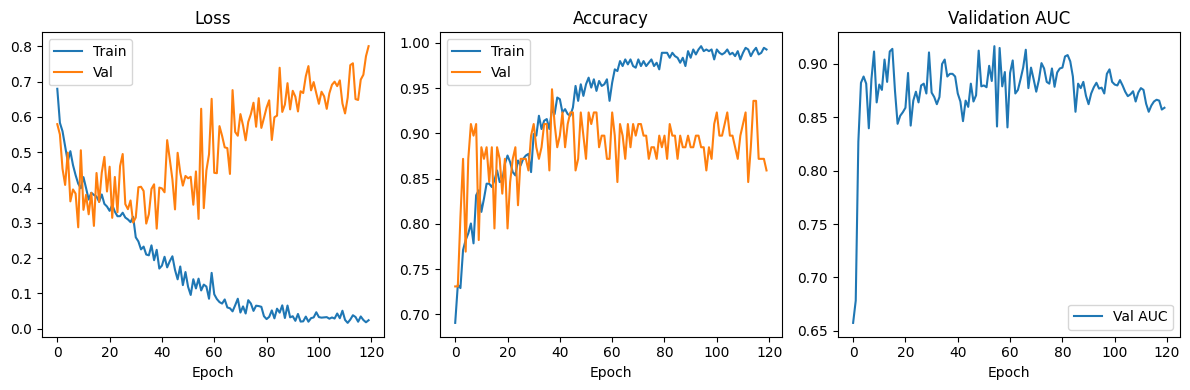


===== Training vit_tiny_patch16_224 with patch size 2 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6042 acc 0.7216 | Val loss 0.5464 acc 0.7308 bal_acc 0.5000 auc 0.7310 | epoch_time 2.51s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5437 acc 0.7363 | Val loss 0.5257 acc 0.7308 bal_acc 0.5000 auc 0.7861 | epoch_time 2.46s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.4982 acc 0.7821 | Val loss 0.4636 acc 0.8205 bal_acc 0.7870 auc 0.8296 | epoch_time 2.64s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5016 acc 0.7821 | Val loss 0.4423 acc 0.8333 bal_acc 0.6905 auc 0.8321 | epoch_time 2.46s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.4655 acc 0.7784 | Val loss 0.3669 acc 0.8590 bal_acc 0.7531 auc 0.8997 | epoch_time 2.47s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.4535 acc 0.7967 | Val loss 0.3444 acc 0.8590 bal_acc 0.7381 auc 0.8772 | epoch_time 2.46s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.4489 acc 0.8004 | Val loss 0.3729 acc 0.8718 bal_acc 0.7619 auc 0.8596 | epoch_time 2.57s
Epoch 8/120

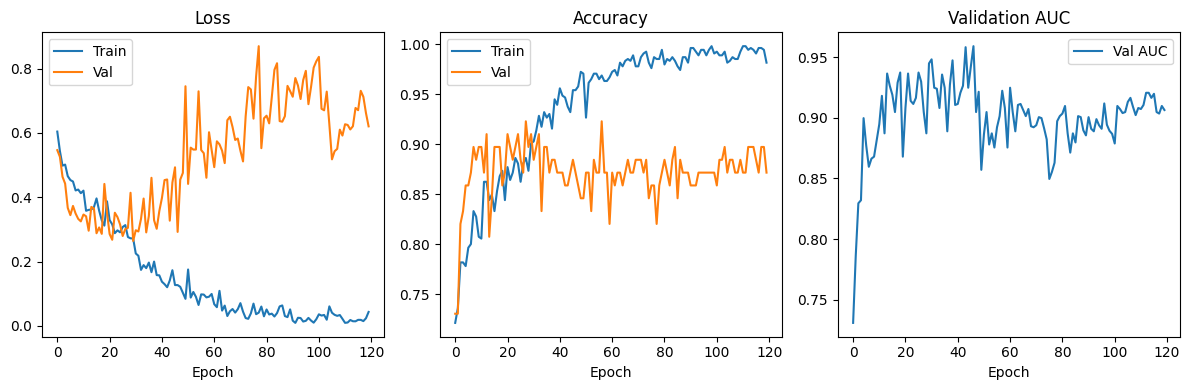


===== Training vit_tiny_patch16_224 with patch size 1 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6533 acc 0.6868 | Val loss 0.5829 acc 0.7308 bal_acc 0.5000 auc 0.6842 | epoch_time 11.75s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5954 acc 0.7308 | Val loss 0.6276 acc 0.7821 bal_acc 0.6253 auc 0.6591 | epoch_time 11.74s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5936 acc 0.7271 | Val loss 0.5589 acc 0.7308 bal_acc 0.5000 auc 0.6332 | epoch_time 11.75s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5522 acc 0.7289 | Val loss 0.5754 acc 0.7308 bal_acc 0.5000 auc 0.7636 | epoch_time 11.75s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5587 acc 0.7289 | Val loss 0.6269 acc 0.6667 bal_acc 0.6817 auc 0.7519 | epoch_time 11.74s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5450 acc 0.7381 | Val loss 0.5218 acc 0.7308 bal_acc 0.5000 auc 0.8195 | epoch_time 11.76s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5162 acc 0.7527 | Val loss 0.4922 acc 0.7821 bal_acc 0.5952 auc 0.7769 | epoch_time 11.74s
Epoc

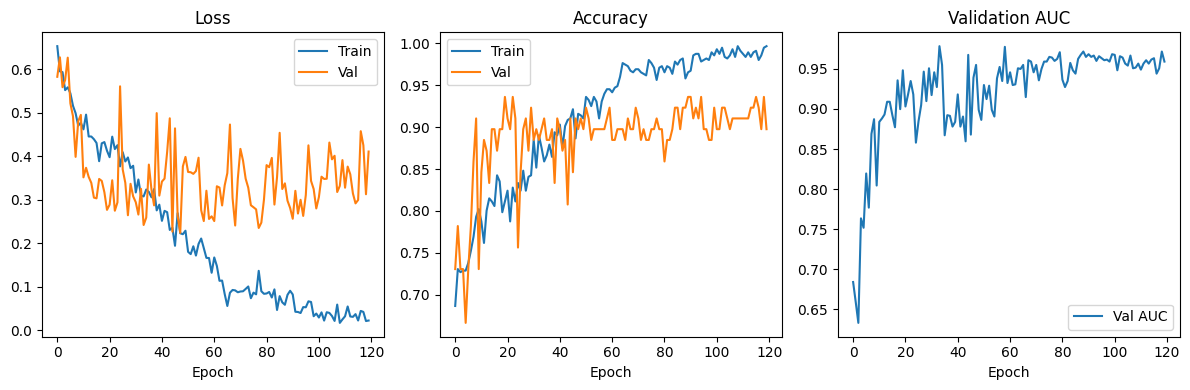

In [ ]:
if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)



===== Training vit_small_patch16_224 with patch size 28 (input 28) =====


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch 1/120 | LR 1.00e-04 | Train loss 0.6308 acc 0.7143 | Val loss 0.5864 acc 0.7308 bal_acc 0.5000 auc 0.6541 | epoch_time 2.41s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5892 acc 0.7308 | Val loss 0.5831 acc 0.7308 bal_acc 0.5000 auc 0.6896 | epoch_time 2.58s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5908 acc 0.7308 | Val loss 0.5873 acc 0.7308 bal_acc 0.5000 auc 0.7185 | epoch_time 2.18s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5896 acc 0.7308 | Val loss 0.5835 acc 0.7308 bal_acc 0.5000 auc 0.7126 | epoch_time 2.22s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5968 acc 0.7308 | Val loss 0.5793 acc 0.7308 bal_acc 0.5000 auc 0.7719 | epoch_time 2.19s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5927 acc 0.7253 | Val loss 0.5839 acc 0.7308 bal_acc 0.5000 auc 0.7577 | epoch_time 2.38s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5817 acc 0.7308 | Val loss 0.5376 acc 0.7308 bal_acc 0.5000 auc 0.7878 | epoch_time 2.51s
Epoch 8/120 | LR 1.00e-04 | Train loss 0.5776 acc 0.7271 | Val loss 0.5695 acc 0.73

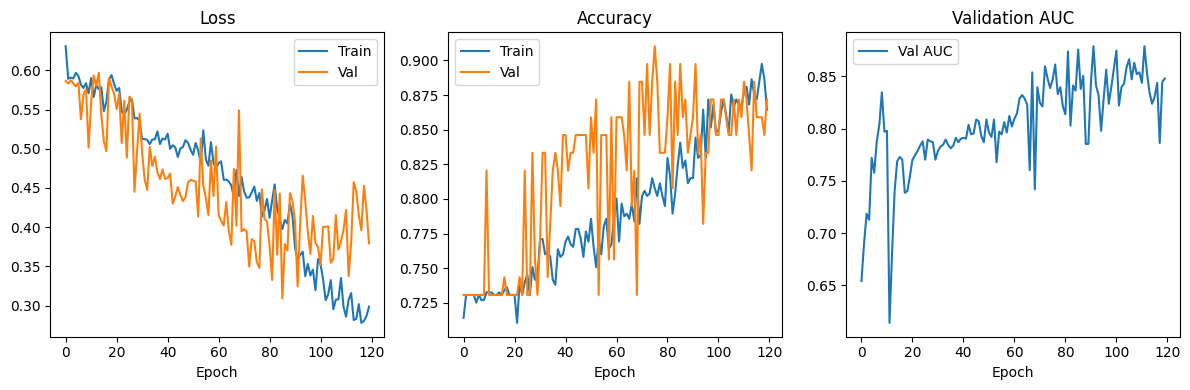


===== Training vit_small_patch16_224 with patch size 14 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6085 acc 0.7234 | Val loss 0.6095 acc 0.7308 bal_acc 0.5000 auc 0.6508 | epoch_time 2.23s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5921 acc 0.7308 | Val loss 0.5880 acc 0.7308 bal_acc 0.5000 auc 0.6934 | epoch_time 2.65s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5853 acc 0.7308 | Val loss 0.5584 acc 0.7308 bal_acc 0.5000 auc 0.7243 | epoch_time 2.27s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5730 acc 0.7326 | Val loss 0.5864 acc 0.7308 bal_acc 0.5000 auc 0.7460 | epoch_time 2.24s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5900 acc 0.7308 | Val loss 0.6182 acc 0.7308 bal_acc 0.5000 auc 0.7018 | epoch_time 2.21s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5453 acc 0.7308 | Val loss 0.6277 acc 0.7308 bal_acc 0.5000 auc 0.7034 | epoch_time 2.19s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5714 acc 0.7179 | Val loss 0.5733 acc 0.8077 bal_acc 0.6579 auc 0.7235 | epoch_time 2.70s
Epoch 8/1

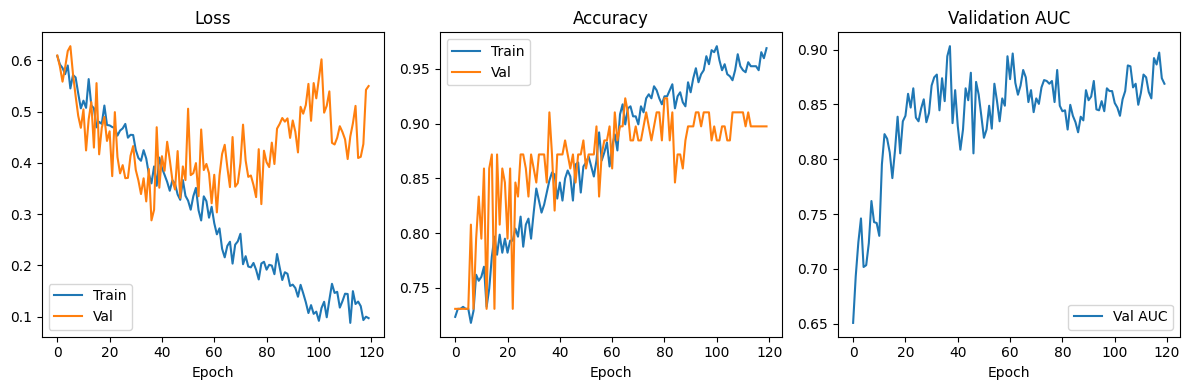


===== Training vit_small_patch16_224 with patch size 7 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6422 acc 0.7161 | Val loss 0.5916 acc 0.7308 bal_acc 0.5000 auc 0.5397 | epoch_time 2.18s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.6013 acc 0.7308 | Val loss 0.5820 acc 0.7308 bal_acc 0.5000 auc 0.7026 | epoch_time 2.21s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5986 acc 0.7289 | Val loss 0.6057 acc 0.7308 bal_acc 0.5000 auc 0.6942 | epoch_time 2.27s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5804 acc 0.7326 | Val loss 0.6748 acc 0.5641 bal_acc 0.6717 auc 0.6909 | epoch_time 2.61s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5910 acc 0.7198 | Val loss 0.5963 acc 0.7308 bal_acc 0.5000 auc 0.6725 | epoch_time 2.18s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5934 acc 0.7308 | Val loss 0.5778 acc 0.7308 bal_acc 0.5000 auc 0.7151 | epoch_time 2.15s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5889 acc 0.7088 | Val loss 0.5861 acc 0.7308 bal_acc 0.5000 auc 0.6274 | epoch_time 2.19s
Epoch 8/12

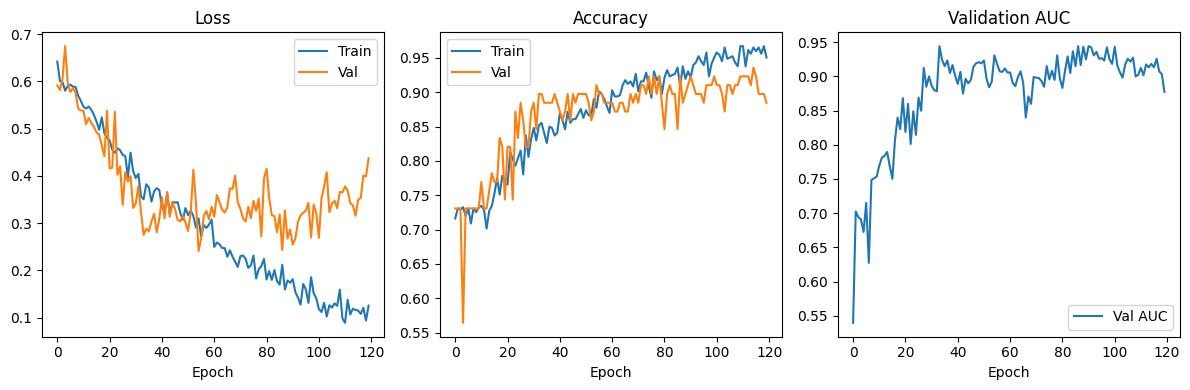


===== Training vit_small_patch16_224 with patch size 4 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6212 acc 0.6978 | Val loss 0.5833 acc 0.7308 bal_acc 0.5000 auc 0.6842 | epoch_time 2.31s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5921 acc 0.7308 | Val loss 0.5776 acc 0.7308 bal_acc 0.5000 auc 0.7034 | epoch_time 2.26s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5853 acc 0.7308 | Val loss 0.5962 acc 0.7308 bal_acc 0.5000 auc 0.6817 | epoch_time 2.76s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5549 acc 0.7289 | Val loss 0.5350 acc 0.7692 bal_acc 0.6466 auc 0.7694 | epoch_time 2.28s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5916 acc 0.7289 | Val loss 0.5384 acc 0.7308 bal_acc 0.5000 auc 0.7970 | epoch_time 2.28s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5392 acc 0.7473 | Val loss 0.5243 acc 0.7436 bal_acc 0.5539 auc 0.7978 | epoch_time 2.26s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5128 acc 0.7656 | Val loss 0.3646 acc 0.8590 bal_acc 0.7682 auc 0.8830 | epoch_time 2.36s
Epoch 8/12

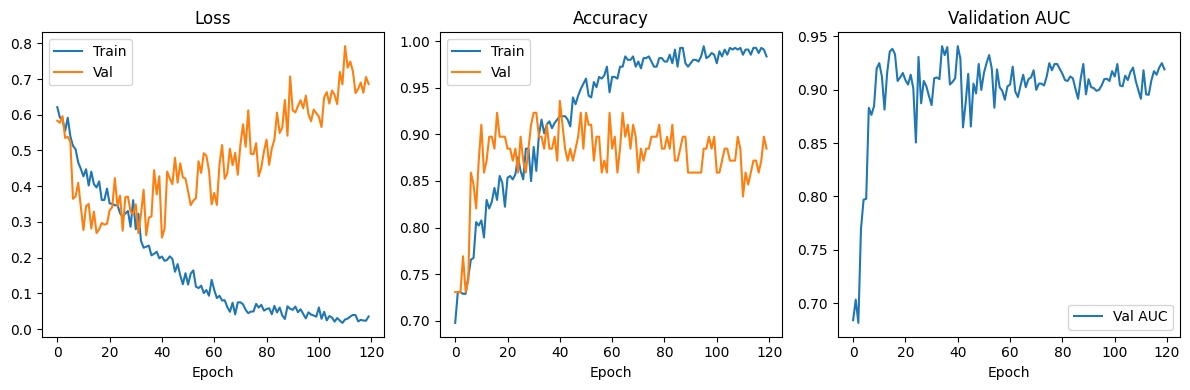


===== Training vit_small_patch16_224 with patch size 2 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6231 acc 0.7289 | Val loss 0.6186 acc 0.7308 bal_acc 0.5000 auc 0.7460 | epoch_time 6.08s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5903 acc 0.7308 | Val loss 0.5852 acc 0.7308 bal_acc 0.5000 auc 0.7360 | epoch_time 6.03s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5493 acc 0.7436 | Val loss 0.4983 acc 0.7821 bal_acc 0.5952 auc 0.8279 | epoch_time 6.09s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5322 acc 0.7491 | Val loss 0.4666 acc 0.8462 bal_acc 0.7143 auc 0.8279 | epoch_time 6.09s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.4732 acc 0.7875 | Val loss 0.3702 acc 0.8718 bal_acc 0.7920 auc 0.8346 | epoch_time 6.09s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.4866 acc 0.7747 | Val loss 0.3820 acc 0.8590 bal_acc 0.7381 auc 0.8471 | epoch_time 6.08s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.4584 acc 0.8004 | Val loss 0.3202 acc 0.8846 bal_acc 0.8308 auc 0.8822 | epoch_time 6.07s
Epoch 8/12

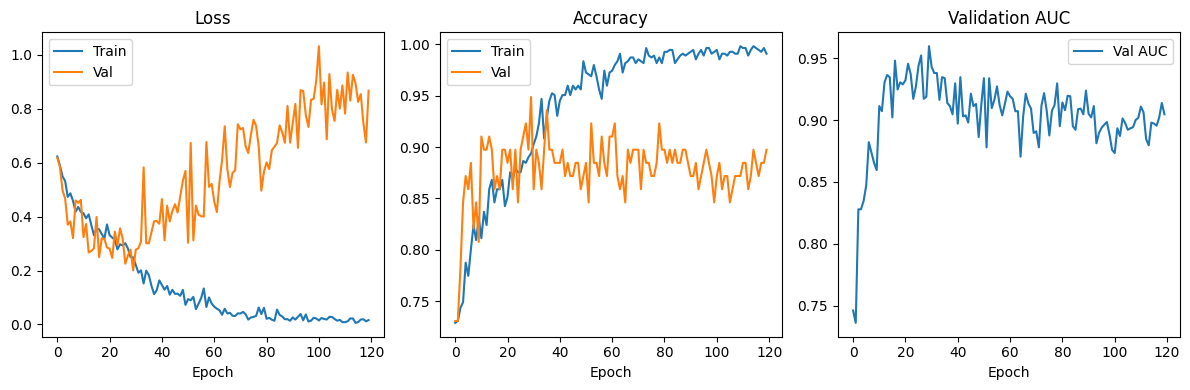


===== Training vit_small_patch16_224 with patch size 1 (input 28) =====
Epoch 1/120 | LR 1.00e-04 | Train loss 0.6185 acc 0.7271 | Val loss 0.5737 acc 0.7308 bal_acc 0.5000 auc 0.6441 | epoch_time 29.11s
Epoch 2/120 | LR 1.00e-04 | Train loss 0.5936 acc 0.7289 | Val loss 0.5850 acc 0.7308 bal_acc 0.5000 auc 0.6784 | epoch_time 29.13s
Epoch 3/120 | LR 1.00e-04 | Train loss 0.5943 acc 0.7198 | Val loss 0.5901 acc 0.7564 bal_acc 0.5627 auc 0.7193 | epoch_time 29.17s
Epoch 4/120 | LR 1.00e-04 | Train loss 0.5708 acc 0.7234 | Val loss 0.5172 acc 0.7308 bal_acc 0.5000 auc 0.7360 | epoch_time 29.24s
Epoch 5/120 | LR 1.00e-04 | Train loss 0.5666 acc 0.7198 | Val loss 0.5727 acc 0.7308 bal_acc 0.5000 auc 0.7778 | epoch_time 29.21s
Epoch 6/120 | LR 1.00e-04 | Train loss 0.5485 acc 0.7399 | Val loss 0.5075 acc 0.7308 bal_acc 0.5000 auc 0.8363 | epoch_time 29.19s
Epoch 7/120 | LR 1.00e-04 | Train loss 0.5198 acc 0.7564 | Val loss 0.4308 acc 0.8333 bal_acc 0.6905 auc 0.8789 | epoch_time 29.18s
Epo

In [ ]:
# Vvit small results
if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)


In [ ]:
# vit base results
if __name__ == "__main__":
    for p in [28,14,7,4,2,1]:
        run_experiment(model_name, patch_size=p)



===== Training vit_tiny_patch16_224 with patch size 28 (input 28) =====
Epoch 1/100 | LR 1.00e-05 | Train loss 0.5894 acc 0.7051 | Val loss 0.5028 acc 0.7308 bal_acc 0.5000 auc 0.8070 | epoch_time 1.93s
Epoch 2/100 | LR 1.00e-05 | Train loss 0.5402 acc 0.7344 | Val loss 0.5404 acc 0.8077 bal_acc 0.7932 auc 0.8463 | epoch_time 1.70s
Epoch 3/100 | LR 1.00e-05 | Train loss 0.5252 acc 0.7582 | Val loss 0.4517 acc 0.8333 bal_acc 0.6905 auc 0.8229 | epoch_time 1.71s
Epoch 4/100 | LR 1.00e-05 | Train loss 0.5203 acc 0.7546 | Val loss 0.4904 acc 0.7436 bal_acc 0.5238 auc 0.8413 | epoch_time 1.74s
Epoch 5/100 | LR 1.00e-05 | Train loss 0.5284 acc 0.7619 | Val loss 0.4551 acc 0.7949 bal_acc 0.6190 auc 0.8446 | epoch_time 1.85s
Epoch 6/100 | LR 1.00e-05 | Train loss 0.5016 acc 0.7692 | Val loss 0.4800 acc 0.7436 bal_acc 0.5238 auc 0.8221 | epoch_time 1.99s
Epoch 7/100 | LR 1.00e-05 | Train loss 0.5062 acc 0.7582 | Val loss 0.4140 acc 0.8462 bal_acc 0.7444 auc 0.8287 | epoch_time 2.11s
Epoch 8/10